Quicker version of Hello World Code. Network created of users and their phone contacts. Nodes are phone numbers and users, connected if user has said phone number in their contact book.

In [207]:
#!pip install psycopg2
#!pip install pandas

import pandas as pd
import psycopg2
from collections import defaultdict
from collections import Counter
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

conn = psycopg2.connect("dbname=XXX user=XXXX host=XXXX port=XXXX password=XXXXX")

Query to select table with all session id's and their phone numbers, their corresponding contacts and the phone numbers of the contacts

In [208]:
cur = conn.cursor()
cur.execute("""SELECT
  contact_books.session_id,
  phone_numbers.phone_number,
  contact_details.key,
  contact_details.value
FROM contact_book_items
  INNER JOIN contact_book_items_phone_numbers
    ON contact_book_items.id = contact_book_items_phone_numbers.contact_book_item_id
  INNER JOIN phone_numbers ON contact_book_items_phone_numbers.phone_number_id = phone_numbers.id
  INNER JOIN contact_books ON contact_book_items.contact_book_id = contact_books.id
  INNER JOIN contact_details ON contact_books.session_id = contact_details.session_id
  LIMIT 1000
  """)
out = cur.fetchall()

In [209]:
dictionary_users_phone_numbers = {}
dictionary_phone_numbers = defaultdict(list)
for row in out:
    if row[2] == "phone_number":
        dictionary_users_phone_numbers[row[0]] = row[3]
    dictionary_phone_numbers[row[0]].append(row[1])
print "number of user contact books included; ", len(dictionary_phone_numbers.keys())


number of user contact books included;  2


In [210]:
nodes = []
node_attributes = {}
edges = []

for user in dictionary_phone_numbers.keys():
    if dictionary_users_phone_numbers[user] in dictionary_phone_numbers.values():
        key = dictionary_users_phone_numbers[user]
    else:
        key = user
    
    nodes.append(key)
    node_attributes[key] = "user"
    for j in dictionary_phone_numbers[user]:
            nodes.append(j)
            node_attributes[j] = "contact"
            edges.append((key,j))


In [211]:
G=nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

nx.set_node_attributes(G,"type of node",node_attributes)
nx.write_gexf(G,"Faster_fiddling.gexf")

print "number of nodes; ", G.number_of_nodes()
print "number of edges; ", G.number_of_edges()


number of nodes;  949
number of edges;  956


Project graph onto just users. I'm also going to add a projection onto contacts. This may be useful in terms of knowing which contacts are more likely to download the app themselves. (a contact who knows more than one person with the app is probably more likely to download the app themselves rather than someone who doesn't know as many people with the app).

This projection is unbelievably interconnected. A network with 3,000 nodes has over 1 million edges - very large amount of connectivity.

In [212]:
#top nodes are users, bottom nodes are their contacts
top_nodes = []
bottom_nodes = []

#dictionary of nodes, with attributes '0' if bottom node and '1' if top node
node_classification = {}
for n in G.nodes():
    if G.node[n]["type of node"] == "user":
        node_classification[n] = 1
        top_nodes += [n]
    else:
        node_classification[n] = 0
        bottom_nodes += [n]

#give nodes new attributes (0 or 1)
nx.set_node_attributes(G,"bipartite",node_classification)
top_nodes = set(top_nodes)
bottom_nodes = set(bottom_nodes)
print "Is graph bipartite?: ", bipartite.is_bipartite(G)

G_projected = bipartite.weighted_projected_graph(G,top_nodes,ratio=True)
G_projected_contacts = bipartite.weighted_projected_graph(G,bottom_nodes,ratio=True)

#remove isolated nodes (those with no connection to the others)
G_projected.remove_nodes_from(nx.isolates(G_projected))
G_projected_contacts.remove_nodes_from(nx.isolates(G_projected))

nx.write_gexf(G_projected,"Faster_projected.gexf")
nx.write_gexf(G_projected_contacts, "Faster_projected_contacts.gexf")

print G_projected.number_of_nodes()
print G_projected.number_of_edges()
print "done"

Is graph bipartite?:  True
2
1
done


Having a fiddle with adding attributes that may be useful later.

In [213]:
cur_new = conn.cursor()
cur_new.execute("""SELECT
  session_id,
  key,
  session_profile_data.value
FROM session_profile_data
""")
out = cur_new.fetchall()

In [214]:
attributes_name = {}
attributes_DOB = {}
for element in out:
    if element[1] == "name":
        attributes_name[element[0]]=element[2]
    if element[1] == "date_of_birth":
        attributes_DOB[element[0]]=element[2]

In [215]:
cur.close()
conn.close()

Edge weight distribution out of interest

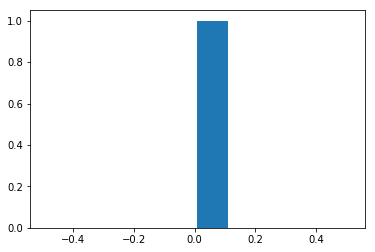

In [216]:
edges = G_projected.edges(G_projected.nodes(),"weight")
weights=[]
for edge in edges:
    weights.append(edge[2])

plt.hist(weights,label="Histogram of Edge Weights")
plt.show()

betweenness centrality is a measure of which nodes in the network are most influential in terms of the flow of information. If we consider 'information' in this case to be a recommendation that leads to a download...attempting to understand what type of person/ user is most successful at bringing in new users.

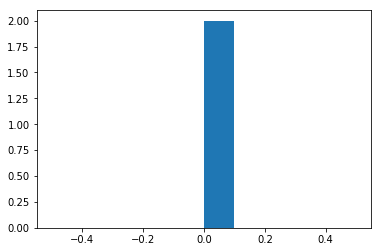

In [217]:
bet_centr = nx.betweenness_centrality(G_projected)
plt.hist(bet_centr.values())
plt.show()

for keys in bet_centr.keys():
    if bet_centr[keys] > 0.01:
        print keys, bet_centr[keys]